# Data Exploration

In [1]:
# Initialize Spark, RERUN EVERY TIME!
from pyspark import SparkConf, SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '50g')

conf = SparkConf()\
        .setMaster("spark://c650mnp06:7077")\
        .setAppName("Sandbox")

sc = SparkContext(conf = conf)

In [2]:
# Index Constants
TRANS_ALLOC = "cast-allocation-ornl"
TRANS_STEP  = "cast-allocation-step-ornl"
STEP_HIST   = "cast-db-csm_step_history-ornl-*"
NODE_HIST   = "cast-db-csm_allocation_node_history-ornl-*"
ALLOC_HIST  = "cast-db-csm_allocation_history-ornl-*"

# Set the Connection Constants
NODES       = "10.7.4.15,10.7.4.17"
PORTS       = "9200"

# Defining Node  History

We want to get some data from the allocation node history table before anything else and leverage Elasticsearch. Step 1 is to determine which fields we want and how we're going to aggregate them (tons of data is great, but skew can be just as if not more interesting) Using this we can start to refine the allocation data to make it easier to run analytics on the allocation data. The following variables are all in the **data** object. The data will be condensed to pivot on the **data.allocation_id**. 

**NOTE:** This is one way of analyzing the data. Other analytics may be written using the raw allocation node data, but I'm interested in a few specific indicators to apply to the overall allocation.

* **memory_usage_max**
    * Should store the Average and the Maximum values.
    * **mem_usage_avg**
    * **mem_usage_max**
* **gpu_usage**
    * Trickier, do we want the total sum or average of all nodes?
    * **gpu_usage_avg**
* **gpfs_read**
    * I think the average across all nodes should be appropriate to get a sense for GPFS usage in general.
    * **gpfs_read_avg**
* **gpfs_write**
    * I think the average across all nodes should be appropriate to get a sense for GPFS usage in general.
    * **gpfs_write_avg**
* **allocation_id**
    * Pivot value, summations and math operations pivot on this data point.
* **cpu_usage**
    * Average should be fine, can show trends. If combined with median, could indicate uneven workload.
    * **cpu_usage_avg**
    * **cpu_usage_median**
* **ib_tx**
    * **ib_tx_avg** 
* **ib_rx**
    * **ib_rx_avg** 
* **energy**
    * **energy_avg**
    * **energy_median**

In [3]:
from datetime import datetime
# Set up the time range
date_format= '%Y-%m-%d'
search_format='date_time_no_millis'

start_time="2019-03-01T01:00:00Z"
end_time="2019-03-02T01:00:00Z"

timerange='''{{
    "lte"    : "{2}",
    "gte"    : "{0}",
    "format" : "{1}"
}}'''.format(start_time, search_format, end_time)
            


In [4]:
# Let's Write a Query!

NHistQuery = '''
{{ 
    "query" : {{
        "range" : {{
             "data.history_time" : {0}
        }}
    }}
}}'''.format(timerange)

#NHistQuery='{ "query":{ "match_all":{ } } }'

print(NHistQuery)
NHistFields = ["data.allocation_id",  "data.ib_tx", "data.ib_rx", "data.memory_usage_max", "data.gpu_usage",
                "data.gpfs_read", "data.gpfs_write", "data.gpu_energy", "data.cpu_usage", "data.energy"]

es_conf = {"es.resource": "{0}".format(NODE_HIST),
          "es.nodes"    : NODES,
          "es.port"     : PORTS,
          "es.query"    : NHistQuery, 
          "es.read.field.include" : ",".join(NHistFields) }



nodeHist = sc.newAPIHadoopRDD("org.elasticsearch.hadoop.mr.EsInputFormat",\
                         "org.apache.hadoop.io.NullWritable", \
                         "org.elasticsearch.hadoop.mr.LinkedMapWritable",conf=es_conf)
nodeHist.first()


{ 
    "query" : {
        "range" : {
             "data.history_time" : {
    "lte"    : "2019-03-02T01:00:00Z",
    "gte"    : "2019-03-01T01:00:00Z",
    "format" : "date_time_no_millis"
}
        }
    }
}


('PKK8_2kBkJgQNSr8Iobe',
 {'data': {'memory_usage_max': 6430654464,
   'gpu_usage': 528201,
   'gpfs_write': 0,
   'gpu_energy': 10928,
   'allocation_id': 194417,
   'ib_rx': 57750,
   'gpfs_read': 0,
   'cpu_usage': 95429015864,
   'ib_tx': 32419,
   'energy': 27503}})

In [5]:
from operator import add

hSchema = (  "allocation_id", ("memory_usage_max", "gpu_usage", "gpfs_write", "gpfs_read", "cpu_usage", "ib_tx", "ib_rx", "energy"))

def mapObj( o ):
    obj  = o[1]["data"]
    
    # Build the tuple, if the field is None  set to 0.
    oTup = tuple( obj[field] if obj[field] is not None  else 0  for field in hSchema[1]  )
    return (obj["allocation_id"], oTup)
    

def reduceObj(x,y):
    return tuple(map(add, x,y))
      


nHistReduced = nodeHist.map(mapObj).reduceByKey(reduceObj)

In [6]:
nHistReduced.first()

(194362,
 (185457836032,
  1765610,
  104258477350912,
  585297821696,
  726322787164,
  317973049627281,
  292074084203098,
  6008032957))

In [7]:
nHistReduced.cache()

PythonRDD[9] at RDD at PythonRDD.scala:53

# Allocation Node History Reduced
At this point we have a full allocation node history.

In [8]:
# Let's Write a Query!

allocQuery = '''
{{ 
    "query" : {{
        "range" : {{
             "data.end_time" : {0}
        }}
    }}
}}'''.format(timerange)

print(allocQuery)
allocFields = ["data.allocation_id"   ,  "data.job_submit_time", "data.begin_time"    , "data.end_time" , 
               "data.projected_memory",   "data.state"         , "data.ssd_min"  , 
               "data.ssd_max"         , "data.user_name"       , "data.num_processors", "data.num_nodes", 
               "data.launch_node_name", "data.time_limit"      , "data.isolated_cores", "data.num_gpus" ]

es_conf = {"es.resource": "{0}".format(ALLOC_HIST),
          "es.nodes"    : NODES,
          "es.port"     : PORTS,
          "es.query"    : allocQuery, 
          "es.read.field.include" : ",".join(allocFields) }



aHist = sc.newAPIHadoopRDD("org.elasticsearch.hadoop.mr.EsInputFormat",\
                         "org.apache.hadoop.io.NullWritable", \
                         "org.elasticsearch.hadoop.mr.LinkedMapWritable",conf=es_conf)
aHist.first()


{ 
    "query" : {
        "range" : {
             "data.end_time" : {
    "lte"    : "2019-03-02T01:00:00Z",
    "gte"    : "2019-03-01T01:00:00Z",
    "format" : "date_time_no_millis"
}
        }
    }
}


('-ydr_WkBkJgQNSr8-OIf',
 {'data': {'projected_memory': 0,
   'ssd_min': 0,
   'num_processors': 0,
   'time_limit': 7200,
   'num_gpus': 0,
   'user_name': 'walksloud',
   'end_time': '2019-03-01 01:00:08.433065',
   'launch_node_name': 'batch3',
   'begin_time': '2019-03-01 00:59:26.029625',
   'num_nodes': 12,
   'allocation_id': 194312,
   'job_submit_time': '2019-03-01 00:58:55',
   'state': 'complete',
   'isolated_cores': 1,
   'ssd_max': 0}})

In [9]:
allocSchema = ("allocation_id"    , ( "job_submit_time", "begin_time"    , "end_time"      ,
               "projected_memory" ,   "state"          , "ssd_min"       ,
                "ssd_max"         ,   "user_name"      , "num_processors", "num_nodes"     , 
                "launch_node_name",   "time_limit"     , "isolated_cores", "num_gpus" ))

def mapAHistObj( o ):
    obj  = o[1]["data"]
    
    # Build the tuple, if the field is None  set to 0.
    oTup = tuple( obj[field] if obj[field] is not None  else 0  for field in allocSchema[1]  )
    return (obj[allocSchema[0]], oTup)


aHistReduced = aHist.map(mapAHistObj)

In [10]:
jSchema = tuple([allocSchema[0]]) + allocSchema[1] + hSchema[1]

def mapJoin(obj):
    return tuple([obj[0]]) + obj[1][0] + obj[1][1]

joinedHist= aHistReduced.join(nHistReduced).map(mapJoin)
joinedHist.cache()

PythonRDD[21] at RDD at PythonRDD.scala:53

In [11]:
# Import the goods.
import json
import math
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pyspark.ml

from pyspark.mllib.stat import Statistics
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Normalizer

from pyspark.mllib.util import MLUtils

import pyspark.sql.functions as F
from pyspark.sql.functions import datediff

from   pyspark.sql import SparkSession



%matplotlib inline 


In [12]:
# Monkey patch  the DataFrame to have a makeDummies function.
def makeDummies(self, colName):
    if self.dummyCols is None:
        self.dummyCols = dict()
        self.dummyCols["_base"] = self.columns
        #del self.dummyCols["_base"][0]
        
        
    categ = self.select(colName).distinct().rdd.flatMap(lambda x: x).collect()
    exps  = [ F.when(F.col(colName) == cat, 1).otherwise(0).alias(str(cat)) for cat in categ ]
    
    self.dummyCols[colName] = categ    
    
    self.dummyCols["_base"].remove(colName)
    
    newDF =  self.select( self.columns  + exps).drop(colName)
    newDF.dummyCols = self.dummyCols
    
    return newDF

def getDummyCols(self, *args):
    if self.dummyCols is None:
        self.dummyCols = dict()

    if len(args) is 0:
        args=self.dummyCols.keys()
        
    dCols = list()
    for col in args :
        dCols += self.dummyCols.get(col, [])
        
    return dCols

def getBase(self):
    if self.dummyCols is not None:
        return self.dummyCols["_base"]
    else:
        return []

def makeDate(self, colName):
    return self.withColumn(colName, self[colName].cast("timestamp"))
  

def dropSafe(self):
    dummyCache=self.dummyCols
    self.drop()
    self.dummyCols=dummyCache
    return self

# Drop any values where Max=Min
def cleanFeatures(self, args ):
    newDF = self
    newDF.dummyCols = self.dummyCols
    for col in args:
        if col is not None:
            des = self.describe(col)
            values = list(map(lambda val :  int(math.floor(float(val))), des.rdd.values().collect()))
            
            # If std is 0, drop the column from the frame.
            if values[3] == values[4]:
                print("Dropping {0} no variance detected".format(col))
                # Cache the dummy cols
                dummyCols = newDF.dummyCols
                newDF = newDF.drop(col)
                
                #  Scan the column table and drop non variant columns.
                for group in dummyCols.keys():
                    if col in dummyCols[group]:
                        dummyCols[group].remove(col)
                        break
                
                newDF.dummyCols = dummyCols
                        
                
                            
    return newDF

def describeList(self, args):    
    for col in args:
        if col is not None:
            des = self.describe(col)
            des.show()       
            
def processDateRange(self, startCol, endCol, deltaField):
    newDF = self.withColumn(deltaField, F .unix_timestamp(endCol) - F.unix_timestamp(startCol))
    
    if self.dummyCols is None:
        self.dummyCols = dict()
        self.dummyCols["_base"] = self.columns
        
    newDF.dummyCols = self.dummyCols
    newDF.dummyCols["_base"].append(deltaField)
    return newDF

def addTimeOfDay(self, *args):
    
    if self.dummyCols is None:
        self.dummyCols = dict()
        self.dummyCols["_base"] = self.columns

    newDF = self
    dummyCols = self.dummyCols
    
    for col in args:
        dummyCols["_base"].append("tod_{0}".format(col))
        dummyCols["_base"].append("tow_{0}".format(col))

        newDF = newDF.withColumn("tod_{0}".format(col), F.hour(self[col]))\
                    .withColumn("tow_{0}".format(col), F.dayofweek(self[col]))
    
    
    newDF.dummyCols = dummyCols       
    return newDF
                                
pyspark.sql.dataframe.DataFrame.makeDummies      = makeDummies
pyspark.sql.dataframe.DataFrame.dummyCols        = None
pyspark.sql.dataframe.DataFrame.makeDate         = makeDate
pyspark.sql.dataframe.DataFrame.getDummyCols     = getDummyCols
pyspark.sql.dataframe.DataFrame.getBase          = getBase
pyspark.sql.dataframe.DataFrame.dropSafe         = dropSafe
pyspark.sql.dataframe.DataFrame.cleanFeatures    = cleanFeatures
pyspark.sql.dataframe.DataFrame.describeList     = describeList
pyspark.sql.dataframe.DataFrame.processDateRange = processDateRange
pyspark.sql.dataframe.DataFrame.addTimeOfDay     = addTimeOfDay

In [13]:
spark = SparkSession(sc)
jDF = joinedHist.toDF(jSchema)

In [14]:
uJDF = jDF.makeDate("job_submit_time")\
    .makeDate("begin_time")\
    .makeDate("end_time")\
    .processDateRange("begin_time","end_time","job_run_time")\
    .processDateRange("job_submit_time","begin_time","submit_to_begin")\
    .processDateRange("job_submit_time","end_time","submit_to_end")\
    .addTimeOfDay("job_submit_time","begin_time","end_time")\
    .makeDummies("launch_node_name")\
    .makeDummies("state")\
    .makeDummies("user_name")


In [15]:
uJDF.describe("tod_begin_time").show()
uJDF.select("begin_time").show()



+-------+------------------+
|summary|    tod_begin_time|
+-------+------------------+
|  count|              1205|
|   mean|10.042323651452282|
| stddev| 6.599912003199741|
|    min|                 0|
|    max|                23|
+-------+------------------+

+--------------------+
|          begin_time|
+--------------------+
|2019-03-01 01:00:...|
|2019-03-01 01:00:...|
|2019-03-01 01:02:...|
|2019-03-01 01:05:...|
|2019-03-01 01:06:...|
|2019-03-01 01:07:...|
|2019-03-01 01:09:...|
|2019-03-01 01:11:...|
|2019-03-01 01:13:...|
|2019-02-28 23:45:...|
|2019-03-01 01:14:...|
|2019-03-01 01:16:...|
|2019-03-01 01:18:...|
|2019-03-01 01:19:...|
|2019-03-01 01:21:...|
|2019-03-01 01:22:...|
|2019-02-28 13:24:...|
|2019-03-01 01:24:...|
|2019-02-28 13:24:...|
|2019-02-28 13:24:...|
+--------------------+
only showing top 20 rows



In [16]:
uJDF        = uJDF.dropSafe()                 # Drop Rows with Null fields
normCols    = uJDF.getDummyCols("_base")[4:]  # Get the columns that need to be normalized.

uJDF        = uJDF.cleanFeatures(normCols)    # Drop columns withh no variance
featureCols = uJDF.getDummyCols()[4:]             # Build the feature columns
normCols    = uJDF.getDummyCols("_base")[4:]  # Get the columns that need to be normalized (changed above)


features    = uJDF.rdd.map(lambda row: row[4:]) # Build the feature rdd.


Dropping projected_memory no variance detected
Dropping ssd_min no variance detected
Dropping ssd_max no variance detected
Dropping num_processors no variance detected
Dropping isolated_cores no variance detected
Dropping num_gpus no variance detected


In [17]:
uJDF.describeList(normCols)

+-------+------------------+
|summary|         num_nodes|
+-------+------------------+
|  count|              1205|
|   mean|  82.5792531120332|
| stddev|264.96741741856044|
|    min|                 1|
|    max|              3072|
+-------+------------------+

+-------+-----------------+
|summary|       time_limit|
+-------+-----------------+
|  count|             1205|
|   mean|7438.705394190872|
| stddev| 8957.66278529704|
|    min|               60|
|    max|            86400|
+-------+-----------------+

+-------+--------------------+
|summary|    memory_usage_max|
+-------+--------------------+
|  count|                1205|
|   mean|5.961298438115107E12|
| stddev|  3.5520744866137E13|
|    min|                   0|
|    max|     608759280697344|
+-------+--------------------+

+-------+--------------------+
|summary|           gpu_usage|
+-------+--------------------+
|  count|                1205|
|   mean|7.139188292475038E11|
| stddev|1.210854526243253...|
|    min|          

In [18]:

corr_matrix = Statistics.corr(features, method="pearson")
pdJDF       = pd.DataFrame(corr_matrix)
pdJDF.index,pdJDF.columns = featureCols,featureCols
pdJDF.head(5)

,num_nodes,time_limit,memory_usage_max,gpu_usage,gpfs_write,gpfs_read,cpu_usage,ib_tx,ib_rx,energy,...,shijin,gabrielgaz,ly15rice,crjones,junqi,orsvuran,jiawl,wozniak,walksloud,bjoo
num_nodes,1.000000,0.171711,0.634111,0.142878,NaN,NaN,0.226686,0.965881,0.963722,NaN,...,-0.036621,-0.013908,-0.008877,0.144928,0.075164,-0.002022,-0.011872,-0.047551,-0.174378,-0.008427
time_limit,0.171711,1.000000,0.065434,0.383028,NaN,NaN,0.396645,0.117195,0.116310,NaN,...,-0.067655,0.021665,-0.000768,0.359569,-0.039808,0.010819,-0.063368,-0.128755,-0.035585,0.050185
memory_usage_max,0.634111,0.065434,1.000000,0.036857,NaN,NaN,0.095125,0.685329,0.683930,NaN,...,-0.020697,-0.009666,-0.004838,0.123135,0.204813,-0.004516,-0.008814,-0.026362,-0.105766,-0.004604
gpu_usage,0.142878,0.383028,0.036857,1.000000,NaN,NaN,0.299623,0.049168,0.049313,NaN,...,-0.007465,-0.003404,-0.001700,-0.001178,-0.003988,-0.001700,-0.005410,-0.009263,-0.038183,0.009275
gpfs_write,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
pdDF = uJDF.toPandas()
pdDF

,allocation_id,job_submit_time,begin_time,end_time,num_nodes,time_limit,memory_usage_max,gpu_usage,gpfs_write,gpfs_read,...,shijin,gabrielgaz,ly15rice,crjones,junqi,orsvuran,jiawl,wozniak,walksloud,bjoo
0,194316,2019-03-01 01:00:17,2019-03-01 01:00:59.264093,2019-03-01 01:01:28.995534,12,7200,185384304640,0,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
1,194313,2019-02-28 01:00:18,2019-03-01 01:00:02.487969,2019-03-01 01:02:16.037971,1,3600,13536198656,0,7.999821e+10,6.936809e+10,...,0,0,0,0,0,0,0,0,0,0
2,194319,2019-03-01 01:02:26,2019-03-01 01:02:55.894098,2019-03-01 01:03:25.755966,12,7200,185604243456,0,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
3,194325,2019-03-01 01:04:42,2019-03-01 01:05:12.860134,2019-03-01 01:05:42.096376,12,7200,185439748096,10973414,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
4,194328,2019-03-01 01:06:26,2019-03-01 01:06:56.024808,2019-03-01 01:07:21.736525,12,7200,185493749760,0,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
5,194331,2019-03-01 01:07:29,2019-03-01 01:07:56.686293,2019-03-01 01:08:26.179756,12,7200,185356517376,0,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
6,194334,2019-03-01 01:09:21,2019-03-01 01:09:53.032015,2019-03-01 01:10:22.803524,12,7200,185385222144,1171606,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
7,194337,2019-03-01 01:11:05,2019-03-01 01:11:35.743839,2019-03-01 01:12:05.235215,12,7200,185437913088,6934276,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
8,194340,2019-03-01 01:12:47,2019-03-01 01:13:16.975176,2019-03-01 01:13:46.058079,12,7200,185379979264,1150802,1.042585e+14,5.852978e+11,...,0,0,0,0,0,0,0,0,1,0
9,194115,2019-02-28 23:45:44,2019-02-28 23:45:49.236109,2019-03-01 01:14:48.001756,32,7200,197227970560,0,2.799468e+10,7.563715e+09,...,0,0,0,0,0,0,0,0,0,0


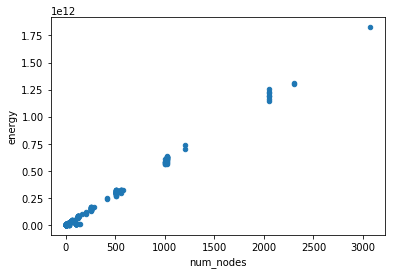

In [20]:
pdDF[["energy","num_nodes"]].plot(x="num_nodes", y="energy", kind="scatter")

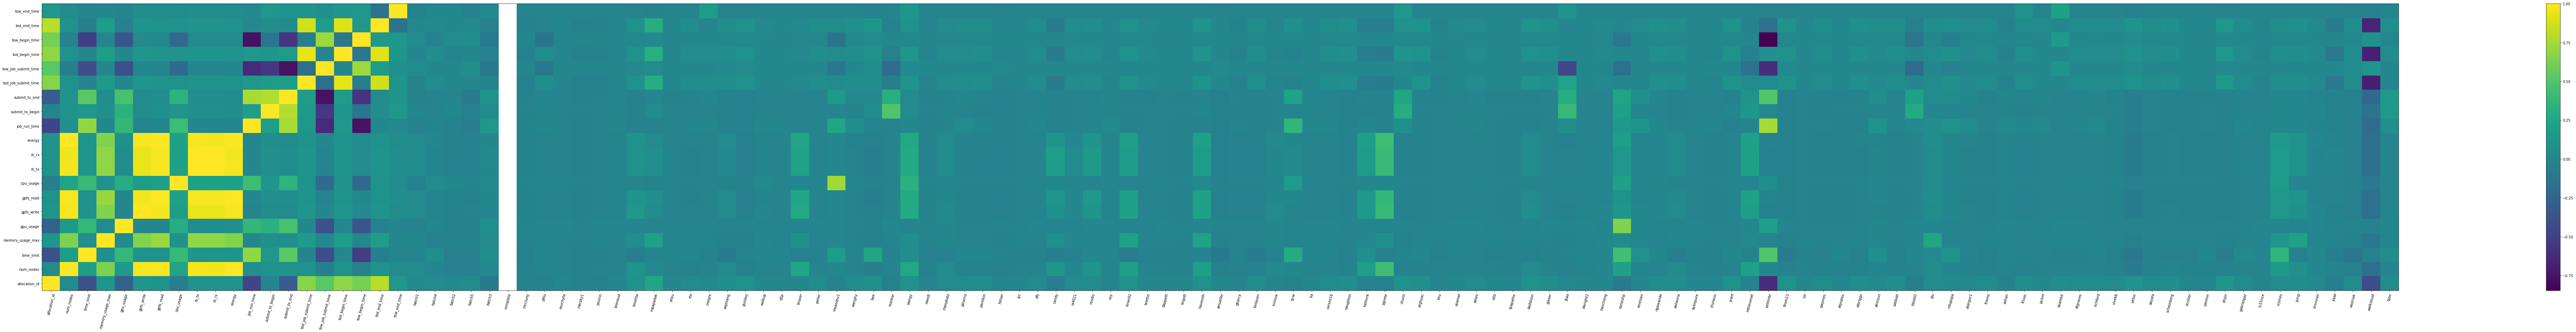

In [21]:
from matplotlib.pyplot import figure

cHeight = len(uJDF.getDummyCols("_base")) - 3 #+ len(uJDF.getDummyCols("launch_node_name"))

# There's a bug in the spark version?
correlation = pdDF.corr()
sCor        = correlation.head(cHeight)


# Let's do a heatmap
# Generate the correlation heat map and axis
fig, ax = plt.subplots()
hm = plt.pcolor(sCor)

fig.set_figheight(15)
fig.set_figwidth(150)

hm.EdgeColor = [1, 0.7, 0.3];
hm.LineWidth = 6;

# Move ticks and labels to the center
ax.set_xticks(np.arange(sCor.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(sCor.shape[0]) + 0.5, minor=False)

# Insert labels
ax.set_xticklabels(sCor.columns, minor=False)
ax.set_yticklabels(sCor.index, minor=False)

# Rotate label
plt.xticks(rotation=75)

# Plot the color guide and show the correlation
plt.colorbar()
plt.show()

In [22]:
# Iterate over the array and just grab things before the split line.
def getPairsToDrop( df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Convert it to a Sequence (I think), aggregate the no-dupe feature set, 
cMag = correlation.abs().unstack()
labels=getPairsToDrop(correlation)
sortedCorrelations = cMag.drop(labels=labels).sort_values(ascending=False)


cCount=0
for idx in sortedCorrelations.index:    
    if sortedCorrelations[idx] < .5 :
        break
    cCount += 1
    print("{2}; {0}, {1}".format(idx[0],idx[1],sortedCorrelations[idx]))
    
print( "\nNumber of correlations with magnitude above .5: ", cCount)

0.9998983579944709; ib_tx, ib_rx
0.9982563224407642; num_nodes, energy
0.9865158477219353; gpfs_read, energy
0.9827150331901601; num_nodes, gpfs_read
0.9784814222287103; gpfs_read, ib_tx
0.9767284317501169; gpfs_write, energy
0.9764486546681131; gpfs_read, ib_rx
0.975905815051472; num_nodes, gpfs_write
0.9726847742868464; ib_tx, energy
0.9704583516378689; ib_rx, energy
0.9685374706857363; gpfs_write, gpfs_read
0.9658810928574603; num_nodes, ib_tx
0.9637215427293057; num_nodes, ib_rx
0.9453862215732124; gpfs_write, ib_tx
0.9412034449124893; gpfs_write, ib_rx
0.9328852163585922; tod_job_submit_time, tod_begin_time
0.9073727465509152; tod_begin_time, tod_end_time
0.8683291917846231; tod_job_submit_time, tod_end_time
0.8462552656359198; tow_begin_time, psteinbr
0.8008964075768714; allocation_id, tod_end_time
0.7801406462484243; submit_to_begin, submit_to_end
0.7630196406378499; submit_to_end, tow_job_submit_time
0.762762412196147; job_run_time, tow_begin_time
0.7583382803876948; job_run_ti

# Correlation assesment

A few interesting notes about this correlation assesment:

## Energy 

```
0.99; num_nodes,        energy
0.98; gpfs_read,        energy
0.97; gpfs_write,       energy
0.97; ib_tx,            energy
0.97; ib_rx,            energy
0.64; memory_usage_max, energy

```

First things first, it looks like in this data set our total `energy `is most strongly correlated to the `num_nodes`. Since `gpfs_read`, `gpfs_write`, `ib_rx`, `ib_tx` and `memory_usage_max` are output values of thhe allocation run, they should be considered dependent values for the sake of prediction. 

The most suprising result of the energy correlation is the `memory_usage_max`; it has a higher magnitude of correlation to the energy usage than the `cpu_usage` and `gpu_usage`. I had expected these two to have a higher impact on the energy than the `memory_usage_max`. That being said, this is merely a model of the correlation, not the amount of energy used. Meaning that `memory_usage_max` increase rose at a similar rate to `energy`.


## GPFS 

```
0.98; num_nodes,        gpfs_read
0.97; gpfs_read,        ib_tx
0.97; gpfs_read,        ib_rx
0.97; num_nodes,        gpfs_write
0.94; gpfs_write,       ib_tx
0.94; gpfs_write,       ib_rx
0.71; memory_usage_max, gpfs_read
0.64; memory_usage_max, gpfs_write
```

A few noteworthy notes about this data. `num_nodes` appears to be the strongest linear predictor for gpfs reads and writes. Since gpfs operations use infiniband the high correlation magnitude for `ib_tx` and `ib_rx` is not suprising to me. It is interesting that `memory_usage_max` has a higher correlation for `gpfs_read` than `gpfs_write`, perhaps this implies a higher cache level for reads, or that writes might have a more logarithmic relationship (need to explore).

## Infiniband

```
0.96; num_nodes, ib_tx
0.96; num_nodes, ib_rx
0.68; memory_usage_max, ib_tx
0.68; memory_usage_max, ib_rx
```

Outside of the already noted gpfs and energy correlations infiniband does have a few more relationships. Unsuprisingly, `num_nodes` is a strong identifier for higher infiniband traffic, not suprising in the slightest considering the gpfs relationships. It looks like infiniband usage has a looser correlation to maximum memory usage.

## Job Run Time

```
0.76; job_run_time, tow_begin_time
0.75; job_run_time, submit_to_end
0.75; job_run_time, psteinbr
0.69; time_limit,   job_run_time
0.62; job_run_time, tow_job_submit_time
```

Interestingly it looks like longer jobs may tend to be begun earlier in the week  (need to actually plot it). There also appears to be some correlation to `time_limit` and `tow_job_submit_time`. Interestingly, there's a correlation with `psteinbr` which is a user category, but since it's categorical thhat might not mean much.


## Other Misc Notes

```
0.63; num_nodes, memory_usage_max
```
`num_nodes` appears to be the best identifier for most of thhe dependent variables.


The other correlations appear to be either tautologies or user related.

# Other Avenues to Explore

* Averages to do per node assesments.
* Standard deviation to find the variance of values.


# Let's GRAPH

In [23]:
# let's bring back some of the Categorical columns

launchNodes = uJDF.getDummyCols("launch_node_name")
users       = uJDF.getDummyCols("user_name")

launch = pdDF[launchNodes].dot(range(0,len(launchNodes)))\
    .map(lambda a : launchNodes[a])
users  = pdDF[users].dot(range(0,len(users)))\
    .map(lambda a : users[a])

launch.name = "launch_nodes"
users.name  = "users"

pdVDF = pd.concat([launch, users, pdDF], axis=1)

In [43]:
# Time to graph!
import matplotlib
import seaborn as sns
from scipy.stats import norm
%matplotlib nbagg
matplotlib.use('nbagg')


#sns.lmplot(x="num_nodes", y="energy", hue="launch_nodes", data=pdVDF)

#sns.lmplot(x="num_nodes", y="energy", data=pdVDF)



#sns.distplot(pdDF['tod_job_submit_time'] )

#sns.lmplot('num_nodes', 'energy', data=pdDF)

# No correlation
#sns.lmplot('tod_job_submit_time', 'energy', data=pdDF)



In [25]:
#plt.xticks(rotation=90)
#sns.countplot(x='num_nodes', hue="launch_nodes", data=pdVDF)
#plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)


In [79]:
%matplotlib inline 

#Launch Nodes per user.
uCS = pdVDF[['users',"launch_nodes","num_nodes"]].groupby(['users',"launch_nodes"]).size()
uCS.names=['users',"launch_nodes","count"]
uCS

uCDF = uCS.to_frame("count").unstack(level=1).reset_index()
uCDF.columns = uCDF.columns.droplevel()
uCDF = uCDF.rename(columns = {"" : "user"})

uCDF = uCDF.melt(id_vars=["user"],value_vars=launchNodes,var_name="launch_node", value_name="count")
lnCDF = uCDF.dropna().sort_values(by="user", ascending=False)


num_nodes
users    launch_nodes             
aayala   batch1           1.000000
         batch3           1.000000
         batch5           1.000000
akorzun  batch1          46.000000
alanger1 batch1           4.000000
         batch3           4.000000
ames     batch4           1.000000
amueller batch1           1.777778
         batch2           1.800000
         batch3           1.000000
         batch4           2.000000
         batch5           2.000000
arghyac  batch1           1.000000
         batch3           1.000000
         batch5           1.000000
ashan    batch4           1.000000
awlauria batch1         256.000000
         batch2         101.000000
         batch3         174.000000
         batch4         256.000000
         batch5          17.500000
ayenpure batch1           1.000000
         batch5           1.000000
azamat   batch1           1.000000
         batch3           1.000000
bee      batch1          40.181818
         batch2          31.272727
         batch3          42.352941
         batch4          39.347826
         batch5          42.560000
...                            ...
wanghy   batch1          32.000000
         batch2          32.000000
         batch3          32.000000
         batch4          32.000000
         batch5          32.000000
wangy    batch1         704.000000
         batch2         512.000000
         batch3         512.000000
         batch4        1024.000000
         batch5         496.000000
wozniak  batch1           3.000000
         batch2           3.000000
         batch3           2.500000
         batch4           1.000000
         batch5           1.800000
wqzhang  batch2         128.333333
         batch3          99.500000
         batch4         171.666667
         batch5         227.400000
xsy      batch3          50.000000
yaomin   batch1           1.000000
         batch3           1.000000
         batch4           1.000000
         batch5           1.000000
yeluo    batch1           1.000000
         batch2           1.000000
         batch3           1.000000
         batch4           1.000000
         batch5           1.000000
z8j      batch3          16.000000

[301 rows x 1 columns]

In [82]:
uCS = pdVDF[['users',"num_nodes"]]
uMDF=uCS.groupby("users").mean().reset_index().sort_values(by="num_nodes", ascending=False)
uMDF.head()

#pdVDF[['users',"launch_nodes","num_nodes"]].groupby(['users',"launch_nodes"]).mean().sort(by="num_nodes", ascending=False)

,users,num_nodes
63,mthevenet,2048.0
73,pgrete,1224.0
78,rameshp,1200.0
21,crjones,1024.0
89,tmaier,1000.0


<IPython.core.display.Javascript object>


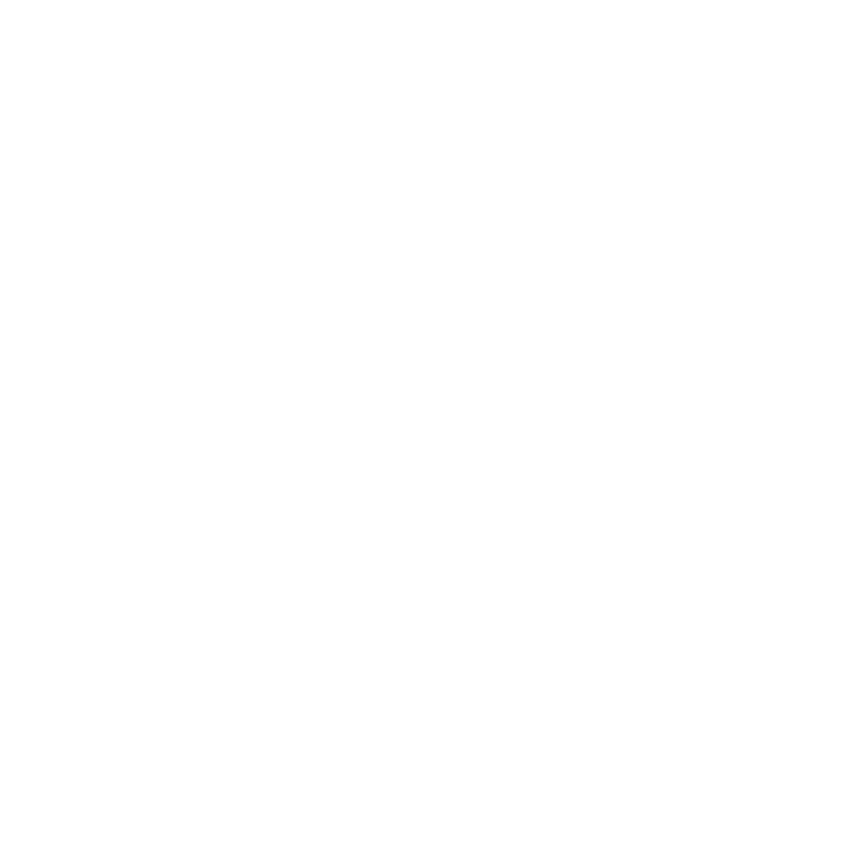

<IPython.core.display.Javascript object>


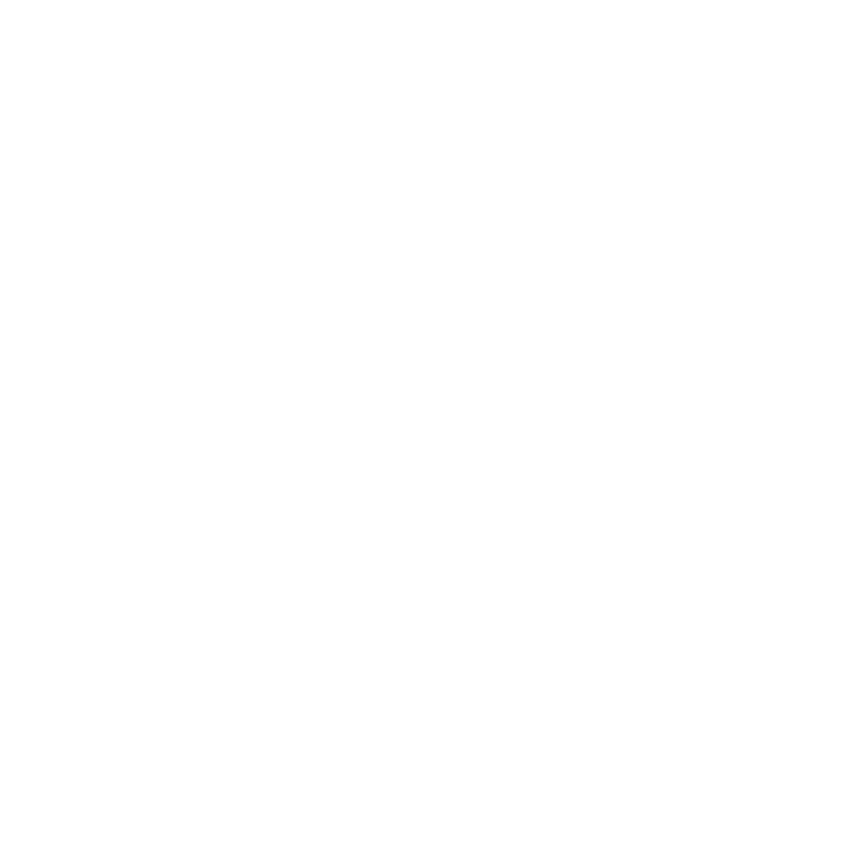

In [94]:
%matplotlib nbagg
matplotlib.use('nbagg')
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)


num_values = 30
labels = ['{0}'.format(n) for n in uMDF["num_nodes"].head(num_values)]

sns.barplot(x='num_nodes',y='users',  data=uMDF.head(num_values))
